In [1]:
'''
author: Yike Xie
data: 11/27/2023
content: compute the RNA type
'''

'\nauthor: Yike Xie\ndata: 11/27/2023\ncontent: compute the RNA type\n'

In [2]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

from statannotations.Annotator import Annotator

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

load features
load dataset
filter genes
Add features to adata


In [5]:
## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata.obs[adata.obs['pct_counts_mt'] < 25].index
dead_cells = adata.obs[adata.obs['pct_counts_mt'] > 25].index

# create dataset only having cells with low percentage of mitochondrial reads
adata_live = adata[live_cells, :]

In [6]:
## Step 1: I create a csv file with gene type from GRCh38 in server by a bash file
'''
#!/bin/bash

# Predefined input and output file paths
INPUT_GTF="path/to/Homo_sapiens.GRCh38.82.gtf"
OUTPUT_CSV="path/to/hs_gene_type.csv"

# Check if the input GTF file exists
if [ ! -f "$INPUT_GTF" ]; then
    echo "Error: Input GTF file not found at $INPUT_GTF"
    exit 1
fi

# Extract gene_id, gene_name, and gene_type using awk
echo "gene_id,gene_name,gene_type" > "$OUTPUT_CSV" # Add header to CSV
awk -F'\t' '$3 == "gene" {
    match($9, /gene_id "([^"]+)"/, gene_id)
    match($9, /gene_name "([^"]+)"/, gene_name)
    match($9, /(gene_biotype|gene_type) "([^"]+)"/, gene_type)
    print gene_id[1] "," gene_name[1] "," gene_type[2]
}' "$INPUT_GTF" >> "$OUTPUT_CSV"

# Confirmation message
echo "Gene annotations saved to $OUTPUT_CSV"
'''

'\n#!/bin/bash\n\n# Predefined input and output file paths\nINPUT_GTF="path/to/Homo_sapiens.GRCh38.82.gtf"\nOUTPUT_CSV="path/to/hs_gene_type.csv"\n\n# Check if the input GTF file exists\nif [ ! -f "$INPUT_GTF" ]; then\n    echo "Error: Input GTF file not found at $INPUT_GTF"\n    exit 1\nfi\n\n# Extract gene_id, gene_name, and gene_type using awk\necho "gene_id,gene_name,gene_type" > "$OUTPUT_CSV" # Add header to CSV\nawk -F\'\t\' \'$3 == "gene" {\n    match($9, /gene_id "([^"]+)"/, gene_id)\n    match($9, /gene_name "([^"]+)"/, gene_name)\n    match($9, /(gene_biotype|gene_type) "([^"]+)"/, gene_type)\n    print gene_id[1] "," gene_name[1] "," gene_type[2]\n}\' "$INPUT_GTF" >> "$OUTPUT_CSV"\n\n# Confirmation message\necho "Gene annotations saved to $OUTPUT_CSV"\n'

In [6]:
## Step 2: add the gene type to adata.obs

annotations = pd.read_csv('./hs_gene_type.csv', sep=',', index_col='gene_name')
# remove duplicated genes
annotations = annotations.loc[~ annotations.index.duplicated()]
# select genes exist in both annotation files and adata # 179 genes are not in the annotation files
common_genes = list(set(annotations.index) & set(adata.var_names))

# create the adata with these common genes
adata_common = adata[:, common_genes].copy()

# add gene types to adata_common
adata_common.var['gene_id'] = annotations.loc[adata_common.var_names]['gene_id'].tolist()
adata_common.var['gene_type'] = annotations.loc[adata_common.var_names]['gene_type'].tolist()

# create the table with the number of gene_type in MT_high and MT_low cells
exp = pd.DataFrame(adata_common.X, index=adata_common.obs_names, columns=adata_common.var_names)

## MT-high vs MT-low cells

In [158]:
# gene expression from adata_common
exp = pd.DataFrame(adata_common.X, index=adata_common.obs_names, columns=adata_common.var_names)
exp.loc['gene_type'] = adata_common.var['gene_type']

# groupby gene type
gene_type_df = exp.T.groupby('gene_type').sum()

# percentage of expression by gene type
gene_pct_df = gene_type_df / gene_type_df.sum(axis=0) * 100

# melt the data for box plot
gene_pct_plot = pd.melt(gene_pct_df.reset_index(), id_vars='gene_type')

# add the group of MT-low or MT-high
gene_pct_plot['MT'] = 'MT-high'
gene_pct_plot.loc[gene_pct_plot['variable'].isin(live_cells), 'MT'] = 'MT-low'

desired_order = [
 'protein_coding',
 'Mt_rRNA',
 'Mt_tRNA',
 'TEC',
 'TR_V_gene',
 'antisense',
 'lincRNA',
 'miRNA',
 'misc_RNA',
 'polymorphic_pseudogene',
 'processed_pseudogene',
 'processed_transcript',
 'scaRNA',
 'sense_intronic',
 'sense_overlapping',
 'snRNA',
 'snoRNA',
 'transcribed_processed_pseudogene',
 'transcribed_unprocessed_pseudogene',
 'unitary_pseudogene',
 'unprocessed_pseudogene'
]

gene_pct_plot['value'] = pd.to_numeric(gene_pct_plot['value'], errors='coerce')
nan_mask = np.isnan(gene_pct_plot['value'])

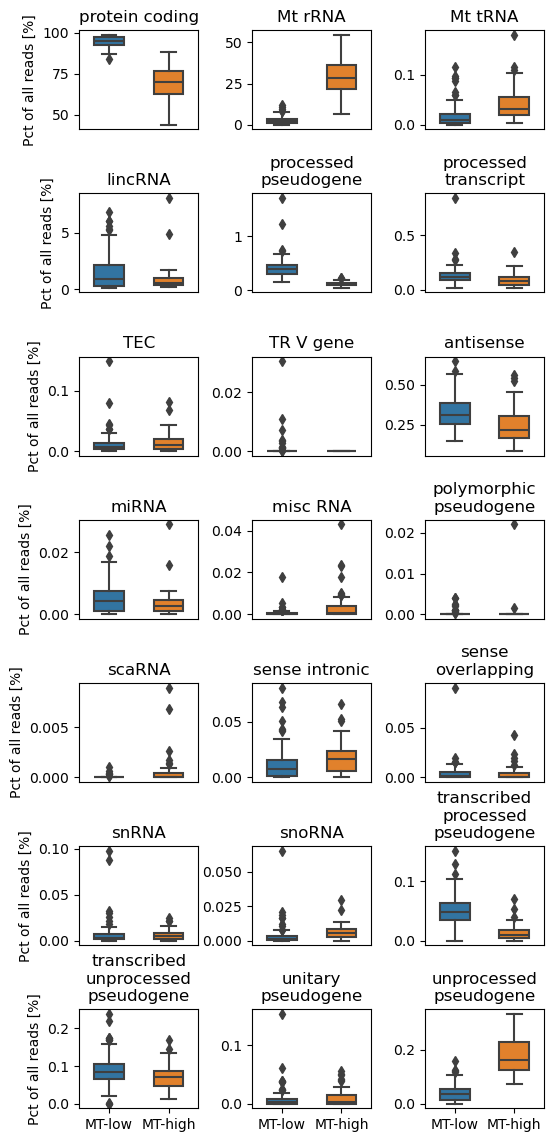

In [222]:
desired_order1 = [
 'protein_coding',
 'Mt_rRNA',
 'Mt_tRNA',
 'lincRNA',
 'processed_pseudogene',
 'processed_transcript',
 'TEC',
 'TR_V_gene',
 'antisense',
 'miRNA',
 'misc_RNA',
 'polymorphic_pseudogene',
 'scaRNA',
 'sense_intronic',
 'sense_overlapping',
 'snRNA',
 'snoRNA',
 'transcribed_processed_pseudogene',
 'transcribed_unprocessed_pseudogene',
 'unitary_pseudogene',
 'unprocessed_pseudogene'
]

fig, axs = plt.subplots(7, 3, figsize=[6, 14])
axs = axs.ravel()

plt.subplots_adjust(wspace=0.45, hspace=0.65)

for i, RNAi in enumerate(desired_order1):
    sns.boxplot(gene_pct_plot[gene_pct_plot['gene_type'] == RNAi], 
            x='MT', y='value', ax=axs[i], width=0.5)
    
    axs[i].set_xlabel(None)
        
    if i in np.arange(len(desired_order1))[::3]:
        axs[i].set_ylabel('Pct of all reads [%]')
    else:
        axs[i].set_ylabel(None)
    
    if i in np.arange(len(desired_order1))[:-3]:    
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])
        
    if len(RNAi) > 14:
        axs[i].set_title('\n'.join(RNAi.split('_')))
    else:
        axs[i].set_title(' '.join(RNAi.split('_')))
        
fig.savefig('./gene_type_pct_MT_all.svg', bbox_inches='tight', dpi=600)

In [223]:
from scipy.stats import ks_2samp
res = []
for RNAi in desired_order1:
    resi = ks_2samp(
    gene_pct_df.loc[RNAi].loc[live_cells].tolist(),
    gene_pct_df.loc[RNAi].loc[~ gene_pct_df.columns.isin(live_cells)].tolist()
                  )
    res.append([resi.statistic, resi.pvalue])
ks_res = pd.DataFrame(res, index=desired_order1, columns=['statistic', 'pvalue'])

# pvals_corrected Benjamini/Hochberg (non-negative)

from statsmodels.stats.multitest import multipletests
adjust_pvalue = multipletests(ks_res['pvalue'], alpha=0.05, method='fdr_bh')[1] 
ks_res['pvalue_corrected (Benjamini/Hochberg)'] = adjust_pvalue

# add min, median, max data for each group
group = 'MT-low'
ks_res[f'{group}_min'] = gene_pct_df[live_cells].loc[desired_order1].min(axis=1)
ks_res[f'{group}_median'] = gene_pct_df[live_cells].loc[desired_order1].median(axis=1)
ks_res[f'{group}_max'] = gene_pct_df[live_cells].loc[desired_order1].max(axis=1)


group = 'MT-high'
ks_res[f'{group}_min'] = gene_pct_df.loc[:, ~ gene_pct_df.columns.isin(live_cells)].loc[desired_order1].min(axis=1)
ks_res[f'{group}_median'] = gene_pct_df.loc[:, ~ gene_pct_df.columns.isin(live_cells)].loc[desired_order1].median(axis=1)
ks_res[f'{group}_max'] = gene_pct_df.loc[:, ~ gene_pct_df.columns.isin(live_cells)].loc[desired_order1].max(axis=1)   

# save data
ks_res.to_csv('./ks_test_gene_type_pct_MT_all.tsv', sep='\t')

## ringed vs unringed cells

In [7]:
## load cell names
fd = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/new_batch/Figure2/'

f = open(fd + 'Top_MT_low_cells.txt', 'r')
unringed_cells = f.read()
unringed_cells = unringed_cells.split('\n')[:-1]

f = open(fd + 'Bottom_MT_low_cells.txt', 'r')
ringed_cells = f.read()
ringed_cells = ringed_cells.split('\n')[:-1]

In [9]:
# gene expression from adata_common
exp = pd.DataFrame(adata_common.X, index=adata_common.obs_names, columns=adata_common.var_names)
exp.loc['gene_type'] = adata_common.var['gene_type']

# groupby gene type
gene_type_df = exp.T.groupby('gene_type').sum()

# percentage of expression by gene type
gene_pct_df = gene_type_df / gene_type_df.sum(axis=0) * 100

# melt the data for box plot
gene_pct_plot = pd.melt(gene_pct_df.reset_index(), id_vars='gene_type')

# add the group of MT-low or MT-high
gene_pct_plot['Group'] = 'Ringed'
gene_pct_plot.loc[gene_pct_plot['variable'].isin(unringed_cells), 'Group'] = 'Unringed'

desired_order = [
 'protein_coding',
 'Mt_rRNA',
 'Mt_tRNA',
 'TEC',
 'TR_V_gene',
 'antisense',
 'lincRNA',
 'miRNA',
 'misc_RNA',
 'polymorphic_pseudogene',
 'processed_pseudogene',
 'processed_transcript',
 'scaRNA',
 'sense_intronic',
 'sense_overlapping',
 'snRNA',
 'snoRNA',
 'transcribed_processed_pseudogene',
 'transcribed_unprocessed_pseudogene',
 'unitary_pseudogene',
 'unprocessed_pseudogene'
]

gene_pct_plot['value'] = pd.to_numeric(gene_pct_plot['value'], errors='coerce')
nan_mask = np.isnan(gene_pct_plot['value'])

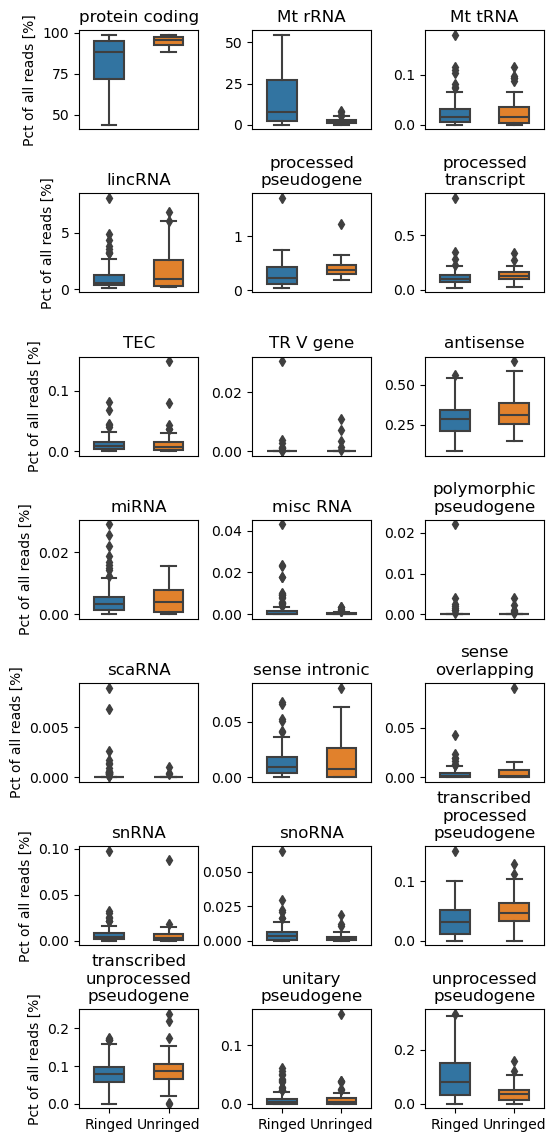

In [13]:
desired_order1 = [
 'protein_coding',
 'Mt_rRNA',
 'Mt_tRNA',
 'lincRNA',
 'processed_pseudogene',
 'processed_transcript',
 'TEC',
 'TR_V_gene',
 'antisense',
 'miRNA',
 'misc_RNA',
 'polymorphic_pseudogene',
 'scaRNA',
 'sense_intronic',
 'sense_overlapping',
 'snRNA',
 'snoRNA',
 'transcribed_processed_pseudogene',
 'transcribed_unprocessed_pseudogene',
 'unitary_pseudogene',
 'unprocessed_pseudogene'
]

fig, axs = plt.subplots(7, 3, figsize=[6, 14])
axs = axs.ravel()

plt.subplots_adjust(wspace=0.45, hspace=0.65)

for i, RNAi in enumerate(desired_order1):
    sns.boxplot(gene_pct_plot[gene_pct_plot['gene_type'] == RNAi], 
            x='Group', y='value', ax=axs[i], width=0.5)
    
    axs[i].set_xlabel(None)
        
    if i in np.arange(len(desired_order1))[::3]:
        axs[i].set_ylabel('Pct of all reads [%]')
    else:
        axs[i].set_ylabel(None)
    
    if i in np.arange(len(desired_order1))[:-3]:    
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])
        
    if len(RNAi) > 14:
        axs[i].set_title('\n'.join(RNAi.split('_')))
    else:
        axs[i].set_title(' '.join(RNAi.split('_')))
        
fig.savefig('./gene_type_pct_ringed_all.png', bbox_inches='tight', dpi=600)

In [12]:
from scipy.stats import ks_2samp
res = []
for RNAi in desired_order1:
    resi = ks_2samp(
    gene_pct_df.loc[RNAi].loc[live_cells].tolist(),
    gene_pct_df.loc[RNAi].loc[~ gene_pct_df.columns.isin(live_cells)].tolist()
                  )
    res.append([resi.statistic, resi.pvalue])
ks_res = pd.DataFrame(res, index=desired_order1, columns=['statistic', 'pvalue'])

# pvals_corrected Benjamini/Hochberg (non-negative)

from statsmodels.stats.multitest import multipletests
adjust_pvalue = multipletests(ks_res['pvalue'], alpha=0.05, method='fdr_bh')[1] 
ks_res['pvalue_corrected (Benjamini/Hochberg)'] = adjust_pvalue

# add min, median, max data for each group
group = 'Ringed'
ks_res[f'{group}_min'] = gene_pct_df[live_cells].loc[desired_order1].min(axis=1)
ks_res[f'{group}_median'] = gene_pct_df[live_cells].loc[desired_order1].median(axis=1)
ks_res[f'{group}_max'] = gene_pct_df[live_cells].loc[desired_order1].max(axis=1)


group = 'Unringed'
ks_res[f'{group}_min'] = gene_pct_df.loc[:, ~ gene_pct_df.columns.isin(live_cells)].loc[desired_order1].min(axis=1)
ks_res[f'{group}_median'] = gene_pct_df.loc[:, ~ gene_pct_df.columns.isin(live_cells)].loc[desired_order1].median(axis=1)
ks_res[f'{group}_max'] = gene_pct_df.loc[:, ~ gene_pct_df.columns.isin(live_cells)].loc[desired_order1].max(axis=1)   

# save data
ks_res.to_csv('./ks_test_gene_type_pct_ringed_all.tsv', sep='\t')